In [103]:
import django
import sys, os
import platform
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
import numpy as np

if platform.node() == "srv-mcc-apsis":
    sys.path.append("/home/galm/software/django/tmv/BasicBrowser/")
    #sys.path.append('/home/leey/tmv/BasicBrowser/')
else:
    # local paths
    sys.path.append('/home/leey/Documents/Data/tmv/BasicBrowser/')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

#import from appended path
import scoping.models as sm
import twitter.models as tm
import parliament.models as pm

from django.db.models import Sum, Count, Q
from django.db.models.fields import DateField
from django.db.models.functions import Cast
import textwrap as tw
import datetime
import random

import scoping.models as sm
import igraph
import mpld3

from adjustText import adjust_text
from matplotlib.collections import LineCollection
from fa2 import ForceAtlas2

In [2]:
def draw_network(ax, g, layout, labels, interactive=False):
    #label_ids = [l['id'] for l in labels]
    x = [x[0] for x in layout]
    y = [x[1] for x in layout]
    c = [v["color"] for v in g.vs if v["color"] is not None]
    
    s = [12 + v["tweets"]*0.15 for v in g.vs]
    lw = [0.1 for v in g.vs ]

    scatter = ax.scatter(x,y,c=c,s=s,edgecolor="black",linewidths=lw)
    

    for e in g.es:#[:1000]:
        s = layout[e.source]
        t = layout[e.target]
        ex = [s[0],t[0]]
        ey = [s[1],t[1]]
        lw = 0.05+(np.log(e['weight']+1)*0.5) #+0.05+(np.log(e['connection_to_n']+1)*5)  #+0.05+np.log(e['connection_to_n'])
        alpha = 0.25
        ax.plot(
            ex,
            ey,
            c="grey",
            lw=lw,
            alpha=alpha,
            zorder=-5
        )    

    texts = []
    for l in labels:
        xy = layout[l["id"]]
        texts.append(ax.text(xy[0],xy[1],l["name"],fontsize=8))

    adjust_text(texts, arrowprops=dict(arrowstyle="->", color='r', lw=0.5))
    for text in texts:
        text.set_alpha(0.7)
        
    ax.grid(False)
    ax.axis('off')
    
    if interactive:
        tooltip =  mpld3.plugins.PointLabelTooltip(
            scatter, 
            labels=[x for x in g.vs["twitter-name"] if x is not None]
        )
        return tooltip

In [19]:
from django.contrib.postgres.aggregates import StringAgg, JSONBAgg

## getting tweets

In [4]:
p = sm.Project.objects.get(pk=196)

In [8]:
start_date = datetime.datetime.strptime('2017-01-01-+0000', '%Y-%m-%d-%z')

In [9]:
end_date = datetime.datetime.strptime('2020-03-01-+0000', '%Y-%m-%d-%z')

In [10]:
# Get tweets related to the project
searches = tm.TwitterSearch.objects.filter(project_list=p)

In [11]:
kohle_ts = tm.TwitterSearch.objects.get(pk=1)

In [12]:
query1 = tm.Status.objects.filter(
    Q(text__icontains = '#klimaschutz') |
    Q(text__icontains = '#hambacherforst') |
    Q(text__icontains = '#hambibleibt') |
    Q(text__icontains = '#endcoal') |
    Q(text__icontains = '#fridaysforfuture') |
    Q(text__icontains = '#klimawandel') |
    Q(text__icontains = '#klima') |
    Q(text__icontains = '#endegelaende') 
).filter(
    searches=kohle_ts
).filter(
    created_at__gte=start_date,
    created_at__lte=end_date
)

In [13]:
query2 = tm.Status.objects.filter(
    searches__in=searches,
    text__isnull=False,
    retweeted_status__isnull=True,
    created_at__gte=start_date,
    created_at__lte=end_date
)

In [14]:
# taking the union of both querysets
qcomb = query1 | query2

In [87]:
qcomb_ids = set(qcomb.values_list('id',flat=True))

---

## Hashtags

### Frequency

In [24]:
hts = []
for t in qcomb.filter(entities__hashtags__iregex='\w'):
    for hashtag in t.entities['hashtags']:
        try:
            ht = [x for x in hts if x['text']=="#"+hashtag['text'].lower()][0]
            ht['count']+=1
        except:
            ht = {"text": "#"+hashtag["text"].lower(), "count": 1}
            hts.append(ht)

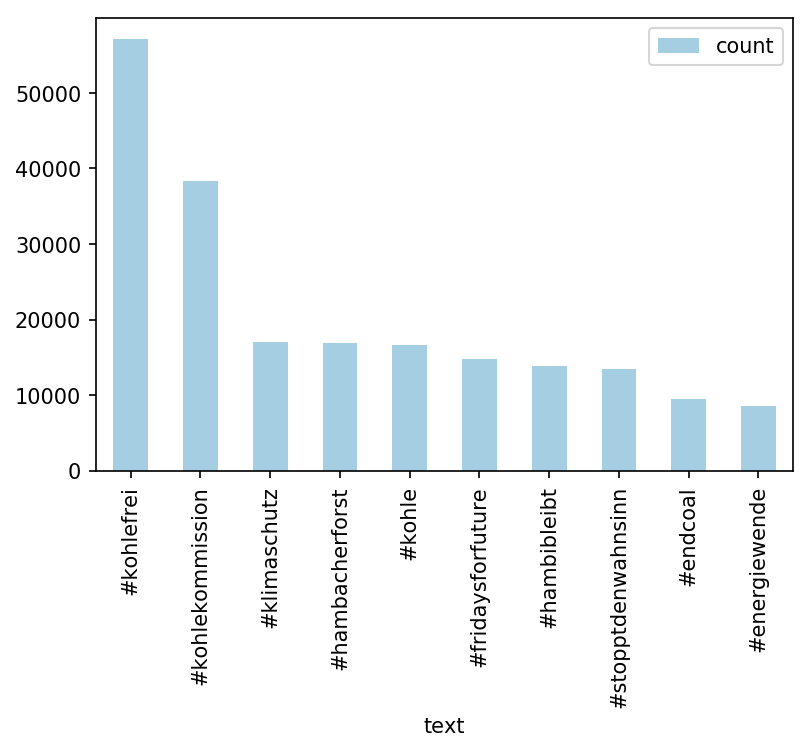

In [25]:
fig, ax = plt.subplots(dpi=150)

ht_df = pd.DataFrame.from_dict(hts).sort_values('count',ascending=False)
ht_df.head(11).tail(10).plot.bar('text','count',colormap='Paired',ax = ax)

plt.show()

### Time

In [27]:
last = qcomb.filter(created_at__isnull=False).order_by('created_at').last().created_at
first = qcomb.filter(created_at__isnull=False).order_by('created_at').first().created_at
first = django.utils.timezone.make_aware(datetime.datetime(2017,1,1))

now = last
all_hts = []
while now > first:
    hts = []
    last = now
    now = now - datetime.timedelta(days=7)
    for t in qcomb.filter(entities__hashtags__iregex='\w', created_at__gt=now, created_at__lte=last):
        for hashtag in t.entities['hashtags']:
            try:
                ht = [x for x in hts if x['text']=="#"+hashtag['text'].lower()][0]
                ht['count']+=1
            except:
                ht = {"week":now, "text": "#"+hashtag["text"].lower(), "count": 1}
                hts.append(ht) 
    all_hts += hts

weekly_ht_df = pd.DataFrame.from_dict(all_hts)

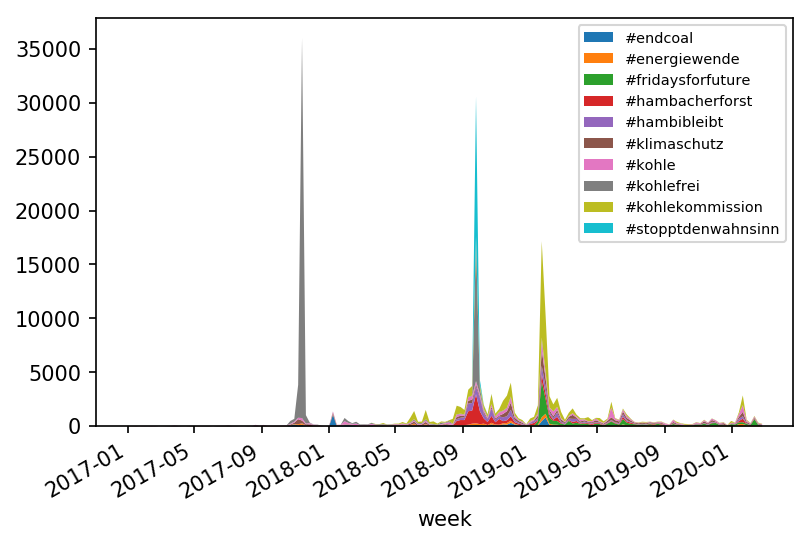

In [50]:
fig, ax = plt.subplots(dpi=150)
ntags = 10
pdf = (weekly_ht_df[weekly_ht_df['text'].isin(ht_df.head(ntags+1).tail(ntags)['text'])]
       .set_index('week')
       .pivot(values="count",columns="text")
       .fillna(0))

#plt.rc('legend',fontsize='small')
fig = pdf.plot.area(ax=ax, linewidth=0)
ax.legend(loc=1, fontsize='x-small')
plt.show()

### Network

In [15]:
min_tweets = 2

In [16]:
user_counts = qcomb.values('author').annotate(
    n = Count('pk')
)

user_counts.filter(n__gt=min_tweets).count()

14231

In [17]:
user_rts = qcomb.filter(
    retweeted_by__isnull=False,
).values('author','retweeted_by').annotate(
    n = Count('pk')
)
print(f"retweeted tweets: {user_rts.count()}")
user_rts.order_by('-n')

from collections import ChainMap
tweeters = set(user_rts.values_list('author',flat=True))
retweeters = set(user_rts.values_list('retweeted_by',flat=True))
print(f"{len(tweeters)} tweeters")
print(f"{len(retweeters)} retweeters")
user_ids = tweeters | retweeters
id_map = [{uid: i} for i,uid in enumerate(user_ids)]
id_map = dict(ChainMap(*id_map))
g = igraph.Graph()
g.add_vertices(len(user_ids))

retweeted tweets: 68366
3747 tweeters
23440 retweeters


In [66]:
# get tweets and user info and aggregate hashtags by user
u_tweets = user_rts.values('author').annotate(
    hts = JSONBAgg("entities__hashtags__text")
)
users = tm.User.objects.filter(pk__in=user_ids).values('pk','name','person__party__colour')
user_dict = {u['pk']: {"name":u["name"],"colour":u["person__party__colour"], "hashtags":None} for u in users}

In [81]:
for u in u_tweets:
    if u['hts'][0] is not None:
        user_dict[u['author']]['hashtags'] = [ht["text"] for ht in u['hts'][0]['hashtags']]

In [88]:
tuids = list(tm.Status.objects.filter(
    pk__in=qcomb_ids,
    retweeted_by__isnull=False
).values_list('author__id',flat=True))
colours = [None] * len(user_ids)
tweet_n = [None] * len(user_ids)
names = [None] * len(user_ids)
hts = [None] * len(user_ids)

for uid, i in id_map.items():
    u = user_dict[uid]
    names[i] = u["name"]
    tweet_n[i] = len([t for t in tuids if t==uid])
    hts[i] = u["hashtags"]
    if u["colour"]:
        colours[i] = u["colour"]
    else:
        colours[i] = "#d3d3d3"
        
g.vs["twitter-name"] = names
g.vs["color"] = colours
g.vs["tweets"] = tweet_n
g.vs["hashtags"] = hts


weights = []
edges = []
for ur in user_rts:
    if ur['author'] in id_map and ur['retweeted_by'] in id_map:
        edges.append((id_map[ur['author']],id_map[ur['retweeted_by']]))
        weights.append(ur['n'])

g.add_edges(edges)
g.es['weight'] = weights

print(g.summary())

IGRAPH U-W- 25205 68366 -- 
+ attr: color (v), hashtags (v), tweets (v), twitter-name (v), weight (e)


In [89]:
sg = g.simplify(combine_edges={ "weight": "sum" }).clusters().giant()
print(sg.summary())

IGRAPH U-W- 24267 67093 -- 
+ attr: color (v), hashtags (v), tweets (v), twitter-name (v), weight (e)


In [121]:
clusters = sg.community_fastgreedy(weights="weight")
#clusters = sg.community_infomap() # very small clusters

#clusters = sg.community_label_propagation() # many small clusters
#clusters = sg.community_spinglass()

#clusters = sg.community_multilevel(weights="weight")
#clusters = sg.community_leiden()

cl = clusters.as_clustering()

In [122]:
print(len(cl), "clusters")
for c in cl:
    print(len(c))

84 clusters
2003
339
5378
3350
833
5
1596
3270
2927
159
1151
73
1383
741
250
9
218
7
9
9
18
4
5
19
6
4
63
3
42
7
8
6
8
10
3
5
4
5
35
4
8
12
22
10
8
3
8
5
18
6
15
5
13
6
10
13
6
3
3
10
3
3
18
4
6
3
4
3
3
7
3
10
2
5
4
3
4
5
2
5
4
4
6
3


In [127]:
layout = sg.layout('fr')
#layout = sg.layout('kk')
#layout = sg.layout('lgl')

---

In [92]:
def chaikins_corner_cutting(coords, refinements=5):

    for _ in range(refinements):
        L = coords.repeat(2, axis=0)
        R = np.empty_like(L)
        R[0] = L[0]
        R[2::2] = L[1:-1:2]
        R[1:-1:2] = L[2::2]
        R[-1] = L[-1]
        coords = L * 0.75 + R * 0.25

    return coords

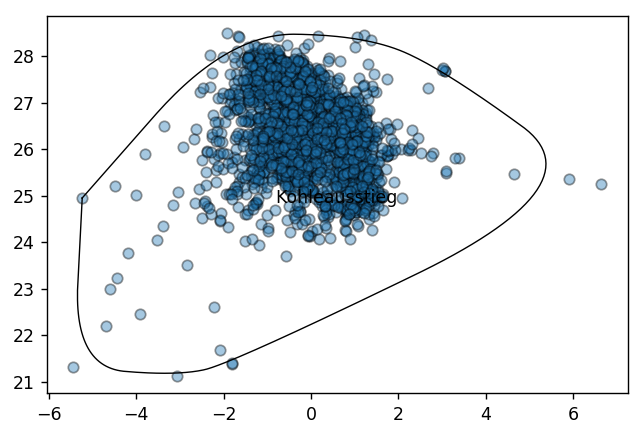

In [115]:
ig, ax = plt.subplots(dpi=125)
from collections import Counter
from scipy.spatial import ConvexHull
c = cl[0]
hts = np.hstack(g.vs[c]['hashtags'])
count = Counter([h for h in hts if h is not None])
count.most_common()[0]
x = [x[0] for i,x in enumerate(layout) if i in c]
y = [x[1] for i,x in enumerate(layout) if i in c] 
cx = np.dot(x, y) / np.sum(y)
scatter = ax.scatter(x,y,edgecolor="black",alpha=0.4)
hts = np.hstack(g.vs[c]['hashtags'])
count = Counter([h for h in hts if h is not None and h!="Wasserstoff"])
if count:
    mc = count.most_common()[0]
    lpoints = np.array(list((zip(x,y))))
    hull = ConvexHull(lpoints)
    cx = np.mean(hull.points[hull.vertices,0])
    cy = np.mean(hull.points[hull.vertices,1])
    c = [cx,cy]
    ax.text(cx,cy,mc[0])
    
    x = lpoints[hull.vertices,0]
    x = np.append(x,[x[:1]])
    y = lpoints[hull.vertices,1]
    y = np.append(y,[y[:1]])
    coords = np.array(list(zip(x,y)))
    coords = chaikins_corner_cutting(coords)


    x2 = coords[:,0]
    y2 = coords[:,1]

    #x2 = interpolate.BSpline(t, x, nt)
    #y2 = interpolate.BSpline(t, y, nt)
    plt.plot(x2, y2,'k-',linewidth=0.8)

In [94]:
hull

NameError: name 'hull' is not defined

In [95]:
vs[0]

NameError: name 'vs' is not defined

QhullError: QH6214 qhull input error: not enough points(2) to construct initial simplex (need 3)

While executing:  | qhull i Qt
Options selected for Qhull 2015.2.r 2016/01/18:
  run-id 1195654959  incidence  Qtriangulate  _pre-merge  _zero-centrum


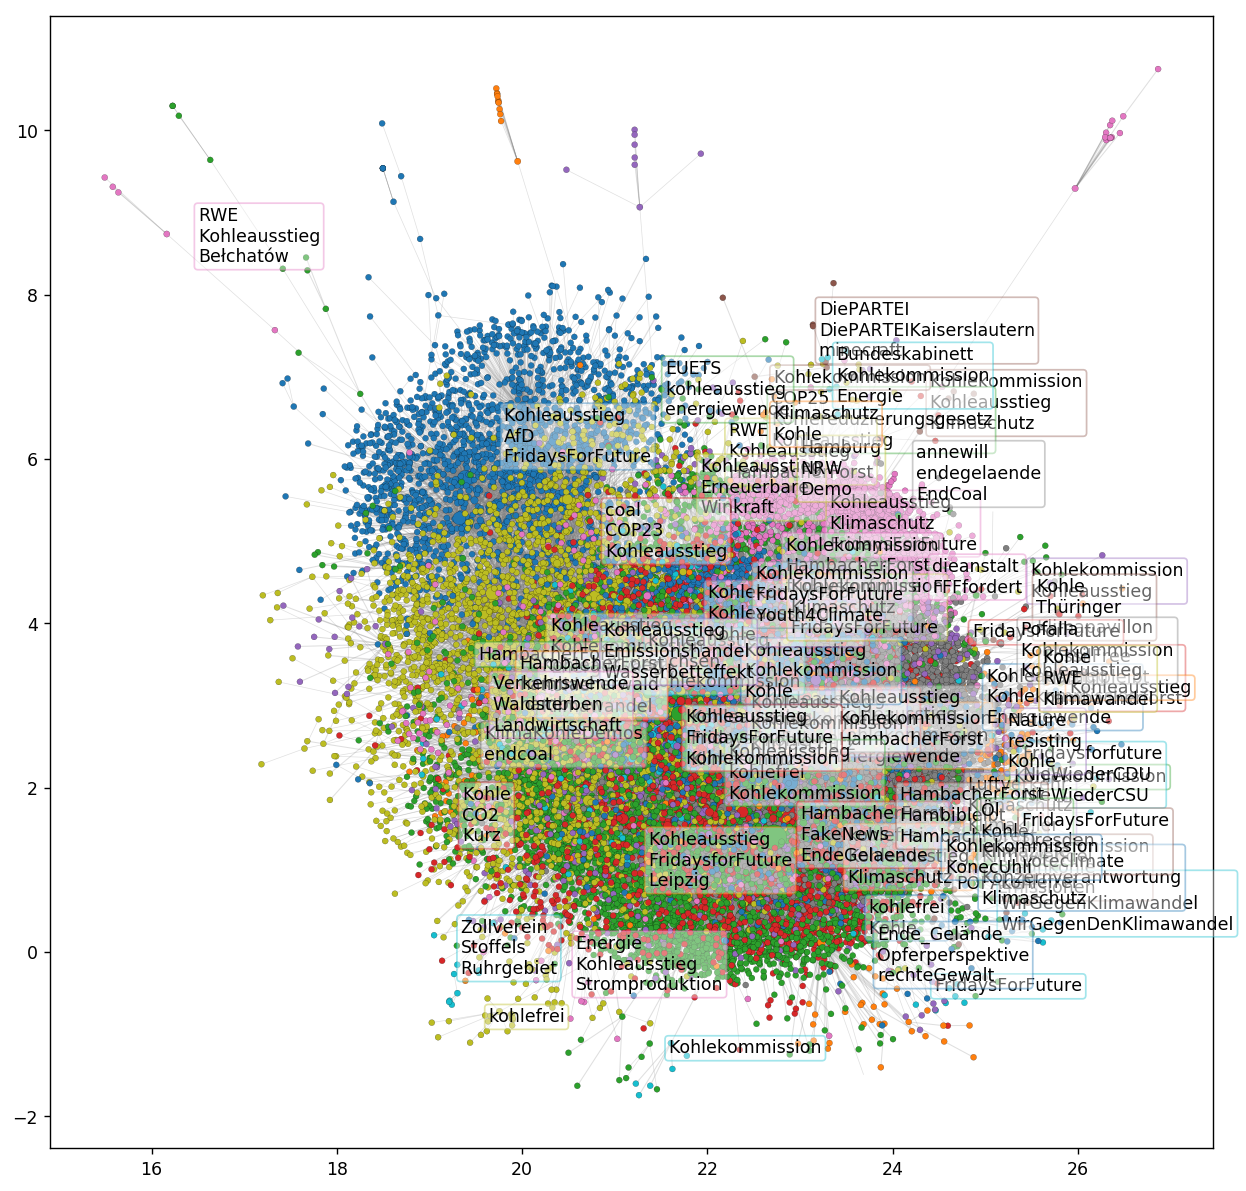

In [128]:
# fr layout
fig, ax = plt.subplots(figsize=(12,12),dpi=125)

alpha = 0.25  
es  = [(layout[e.source],layout[e.target]) for e in sg.es]
lw = [0.05+(np.log(e['weight']+1)*0.5) for e in sg.es]
lc = LineCollection(es,colors="grey",alpha=alpha,linewidths=lw,zorder=-1)
ax.add_collection(lc)
    
for c in cl:
    x = [x[0] for i,x in enumerate(layout) if i in c]
    y = [x[1] for i,x in enumerate(layout) if i in c] 
    vs = sg.vs[c]
    col = [v["color"] for v in vs if v["color"] is not None]
    s = [12 + v["tweets"]*0.15 for v in vs]
    lw = [0.1 for v in g.vs ]
    scatter = ax.scatter(x,y,s=s,edgecolor="black",linewidths=lw)
    #scatter = ax.scatter(x,y,c=col,s=s,edgecolor="black",linewidths=lw)
    hts = np.hstack(vs['hashtags'])
    count = Counter([h for h in hts if h is not None and h!="Wasserstoff"])
    if count:
        
        mct = count.most_common()[0][0]
        mct = "\n".join([t[0] for t in count.most_common()[:3]])
        lpoints = np.array(list((zip(x,y))))
        hull = ConvexHull(lpoints)
        cx = np.mean(hull.points[hull.vertices,0])
        cy = np.mean(hull.points[hull.vertices,1])
        cx = np.mean(x)
        cy = np.mean(y)
        c = [cx,cy]
        ax.text(cx,cy,mct,zorder=5, bbox={
            'facecolor':"white", 'alpha':0.4, 'pad':0.2, 'boxstyle': 'round',
            'edgecolor': scatter._facecolors[0]
        })
        
ax.grid(False)
ax.axis('off')

plt.show()

QhullError: QH6214 qhull input error: not enough points(2) to construct initial simplex (need 3)

While executing:  | qhull i Qt
Options selected for Qhull 2015.2.r 2016/01/18:
  run-id 1978729539  incidence  Qtriangulate  _pre-merge  _zero-centrum


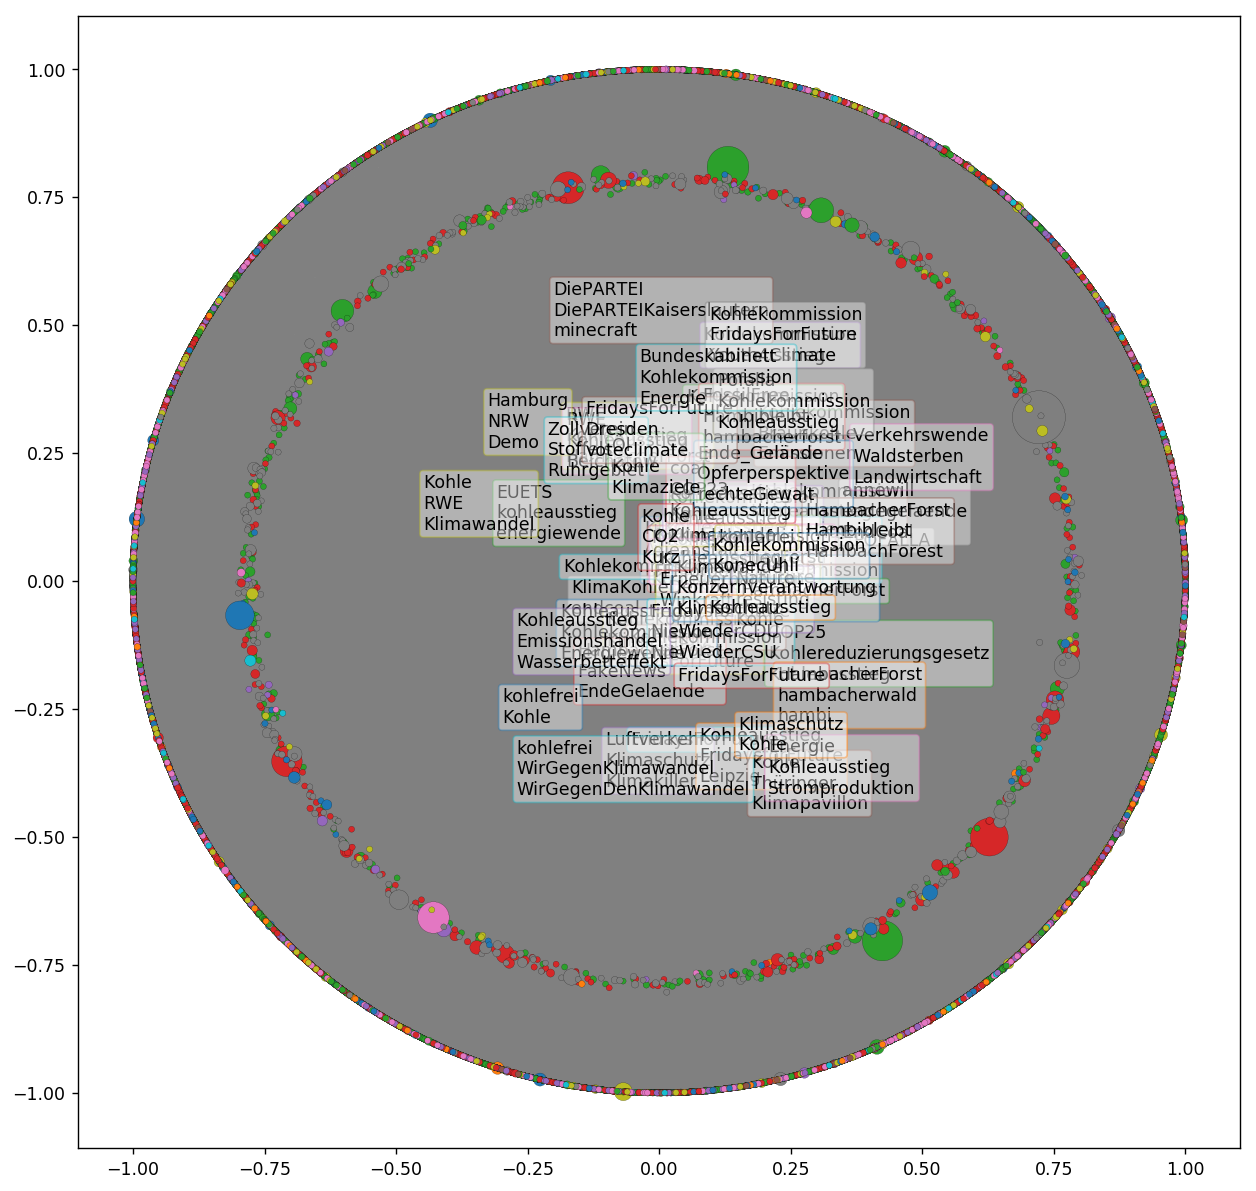

In [124]:
# kk layout
fig, ax = plt.subplots(figsize=(12,12),dpi=125)

alpha = 0.25  
es  = [(layout[e.source],layout[e.target]) for e in sg.es]
lw = [0.05+(np.log(e['weight']+1)*0.5) for e in sg.es]
lc = LineCollection(es,colors="grey",alpha=alpha,linewidths=lw,zorder=-1)
ax.add_collection(lc)
    
for c in cl:
    x = [x[0] for i,x in enumerate(layout) if i in c]
    y = [x[1] for i,x in enumerate(layout) if i in c] 
    vs = sg.vs[c]
    col = [v["color"] for v in vs if v["color"] is not None]
    s = [12 + v["tweets"]*0.15 for v in vs]
    lw = [0.1 for v in g.vs ]
    scatter = ax.scatter(x,y,s=s,edgecolor="black",linewidths=lw)
    #scatter = ax.scatter(x,y,c=col,s=s,edgecolor="black",linewidths=lw)
    hts = np.hstack(vs['hashtags'])
    count = Counter([h for h in hts if h is not None and h!="Wasserstoff"])
    if count:
        
        mct = count.most_common()[0][0]
        mct = "\n".join([t[0] for t in count.most_common()[:3]])
        lpoints = np.array(list((zip(x,y))))
        hull = ConvexHull(lpoints)
        cx = np.mean(hull.points[hull.vertices,0])
        cy = np.mean(hull.points[hull.vertices,1])
        cx = np.mean(x)
        cy = np.mean(y)
        c = [cx,cy]
        ax.text(cx,cy,mct,zorder=5, bbox={
            'facecolor':"white", 'alpha':0.4, 'pad':0.2, 'boxstyle': 'round',
            'edgecolor': scatter._facecolors[0]
        })
        
ax.grid(False)
ax.axis('off')

plt.show()

QhullError: QH6214 qhull input error: not enough points(2) to construct initial simplex (need 3)

While executing:  | qhull i Qt
Options selected for Qhull 2015.2.r 2016/01/18:
  run-id 1164057799  incidence  Qtriangulate  _pre-merge  _zero-centrum


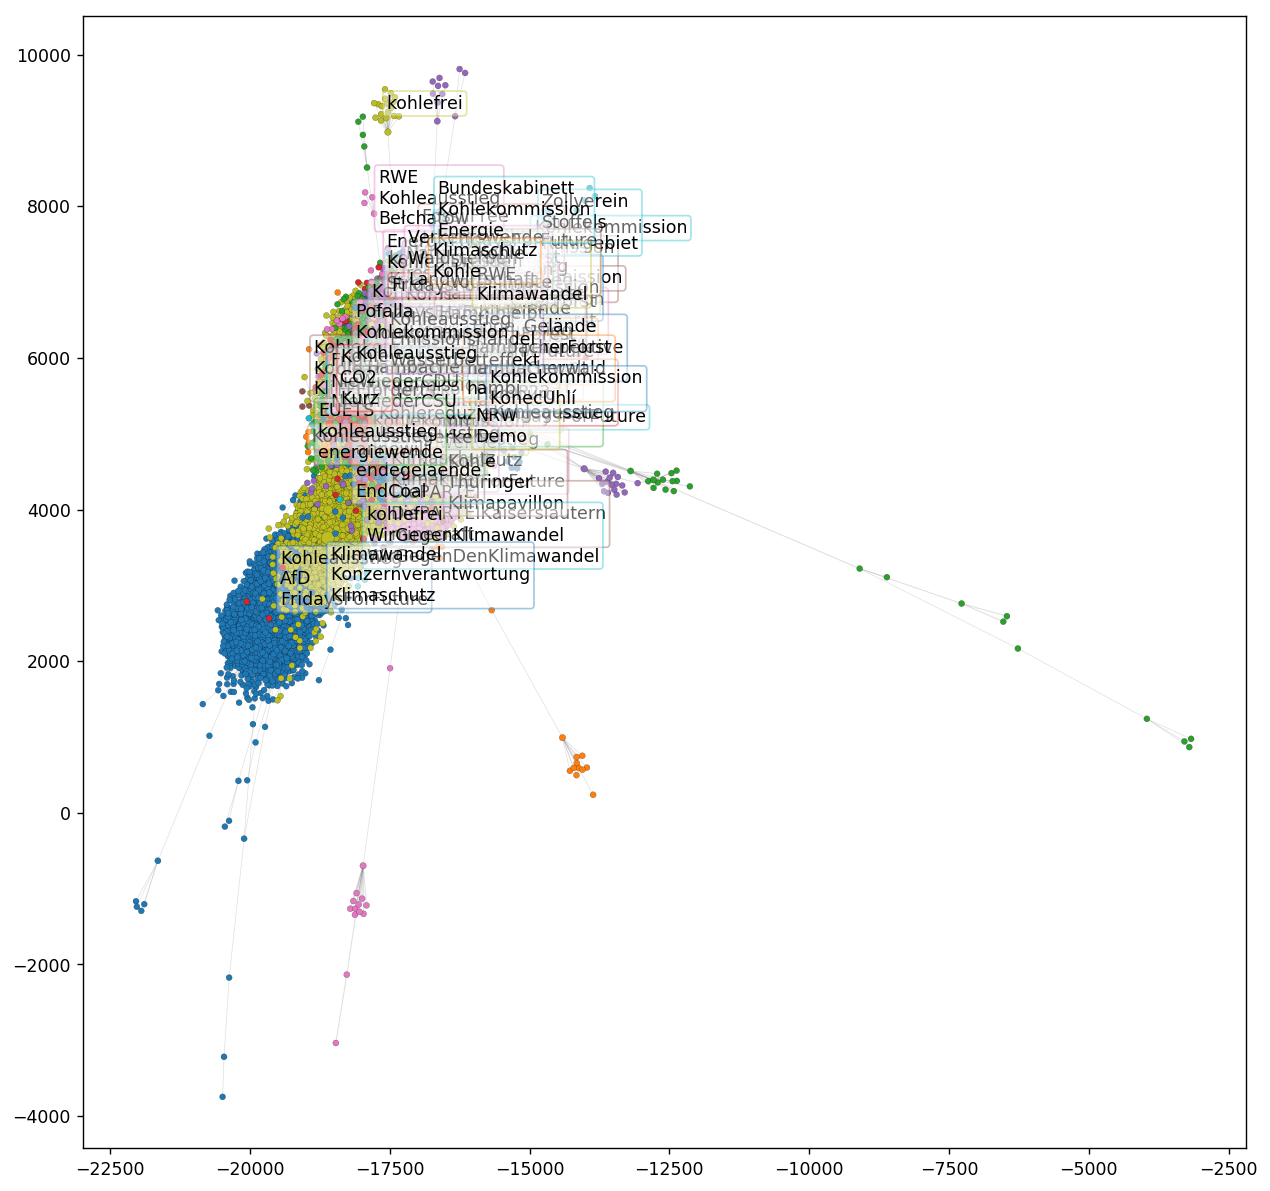

In [126]:
# lgl layout
fig, ax = plt.subplots(figsize=(12,12),dpi=125)

alpha = 0.25  
es  = [(layout[e.source],layout[e.target]) for e in sg.es]
lw = [0.05+(np.log(e['weight']+1)*0.5) for e in sg.es]
lc = LineCollection(es,colors="grey",alpha=alpha,linewidths=lw,zorder=-1)
ax.add_collection(lc)
    
for c in cl:
    x = [x[0] for i,x in enumerate(layout) if i in c]
    y = [x[1] for i,x in enumerate(layout) if i in c] 
    vs = sg.vs[c]
    col = [v["color"] for v in vs if v["color"] is not None]
    s = [12 + v["tweets"]*0.15 for v in vs]
    lw = [0.1 for v in g.vs ]
    scatter = ax.scatter(x,y,s=s,edgecolor="black",linewidths=lw)
    #scatter = ax.scatter(x,y,c=col,s=s,edgecolor="black",linewidths=lw)
    hts = np.hstack(vs['hashtags'])
    count = Counter([h for h in hts if h is not None and h!="Wasserstoff"])
    if count:
        
        mct = count.most_common()[0][0]
        mct = "\n".join([t[0] for t in count.most_common()[:3]])
        lpoints = np.array(list((zip(x,y))))
        hull = ConvexHull(lpoints)
        cx = np.mean(hull.points[hull.vertices,0])
        cy = np.mean(hull.points[hull.vertices,1])
        cx = np.mean(x)
        cy = np.mean(y)
        c = [cx,cy]
        ax.text(cx,cy,mct,zorder=5, bbox={
            'facecolor':"white", 'alpha':0.4, 'pad':0.2, 'boxstyle': 'round',
            'edgecolor': scatter._facecolors[0]
        })
        
ax.grid(False)
ax.axis('off')

plt.show()

---

In [16]:
# old do not run 
tuids = list(qcomb.filter(retweeted_by__isnull=False).values_list('author__id',flat=True))
colours = [None] * len(user_ids)
tweet_n = [None] * len(user_ids)
names = [None] * len(user_ids)

for uid, i in id_map.items():
    u = tm.User.objects.get(pk=uid)
    names[i] = u.name
    tweet_n[i] = len([t for t in tuids if t==uid])
    if u.person:
        colours[i] = u.person.party.colour
    else:
        colours[i] = "#d3d3d3"
        
g.vs["twitter-name"] = names
g.vs["color"] = colours
g.vs["tweets"] = tweet_n


weights = []
edges = []
for ur in user_rts:
    if ur['author'] in id_map and ur['retweeted_by'] in id_map:
        edges.append((id_map[ur['author']],id_map[ur['retweeted_by']]))
        weights.append(ur['n'])

g.add_edges(edges)
g.es['weight'] = weights

print(g.summary())

IGRAPH U-W- 10135 19976 -- 
+ attr: color (v), tweets (v), twitter-name (v), weight (e)


In [110]:
gn = g.clusters().giant()

ig_layout = gn.layout("fr")

labels = []
for i, d in enumerate(gn.degree()):
    if d > 5:
        labels.append({
            "id": i,
            "name": gn.vs["twitter-name"][i],
            "d": d 
        })
        
labels = sorted(labels, key=lambda k: k['d'], reverse=True)

In [111]:
labels[:50]

[{'d': 2603, 'id': 5483, 'name': 'Fridays For Future Germany'},
 {'d': 2354, 'id': 20332, 'name': 'Volker Quaschning'},
 {'d': 2326, 'id': 1592, 'name': 'Ende Gelände'},
 {'d': 2119, 'id': 15957, 'name': 'Tilo'},
 {'d': 1541, 'id': 21649, 'name': 'Greenpeace e.V.'},
 {'d': 1314, 'id': 12435, 'name': 'Klima-Allianz Deutschland'},
 {'d': 1169, 'id': 6950, 'name': 'Jürgen Döschner'},
 {'d': 1153, 'id': 13883, 'name': 'campact'},
 {'d': 1097, 'id': 3254, 'name': 'Kräuter | Verbena'},
 {'d': 889, 'id': 4546, 'name': 'WWF Deutschland | #EarthHour 💡'},
 {'d': 752, 'id': 9333, 'name': 'Oliver Krischer'},
 {'d': 738, 'id': 6600, 'name': 'Sebastian Hornschild 🇪🇺'},
 {'d': 618, 'id': 23501, 'name': 'Hambacher Forst'},
 {'d': 593, 'id': 3659, 'name': 'Kohle-Protest'},
 {'d': 458, 'id': 11664, 'name': 'Tιllмαии'},
 {'d': 439, 'id': 22989, 'name': 'Karsten Smid'},
 {'d': 434, 'id': 16699, 'name': 'UmweltinstitutM e.V.'},
 {'d': 414, 'id': 6596, 'name': 'Malte Kreutzfeldt'},
 {'d': 401, 'id': 19848, 

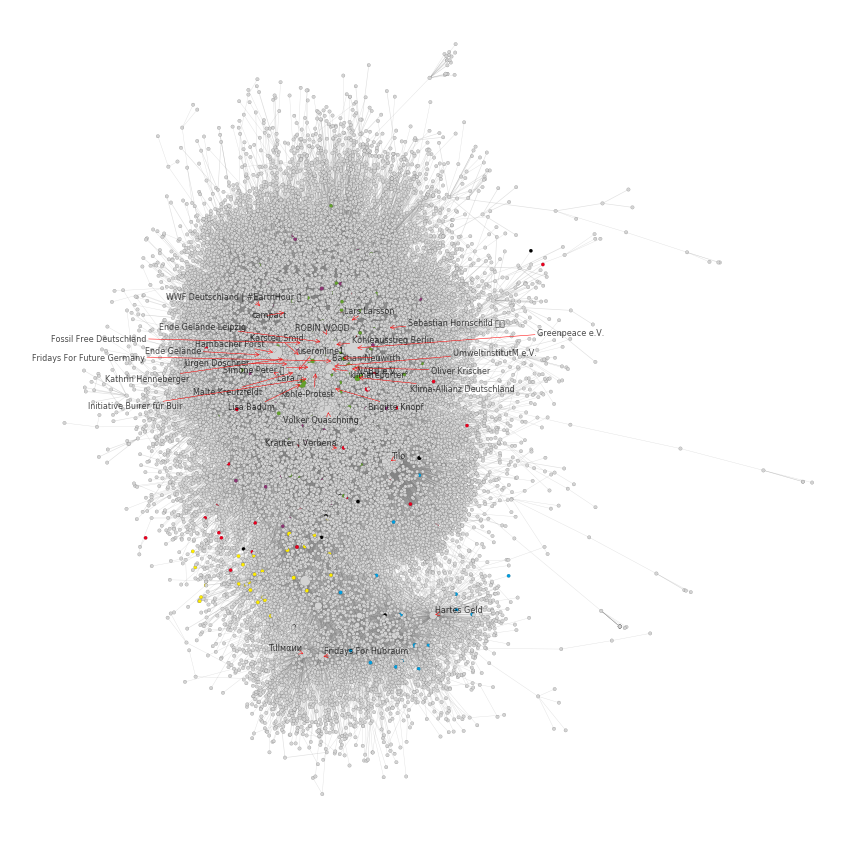

In [112]:
fig, ax = plt.subplots(figsize=(12,12))

draw_network(ax, gn, ig_layout, labels[:35])

fig.tight_layout()

#plt.savefig('plots/rt_network_coal.png', bbox_inches="tight")

plt.show()

In [23]:
# clustering algorithm 
g.community_fastgreedy()

InternalError: Error at fast_community.c:553: fast-greedy community finding works only on graphs without multiple edges, Invalid value

In [42]:
# identify communities
communities = g.community_multilevel()
# identify number of communities
max(communities.membership)

22

In [45]:
len(communities.membership)

9955

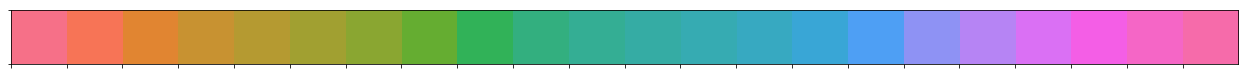

In [44]:
sns.palplot(sns.color_palette("husl", 22))